In [ ]:
import numpy as np
import pandas as pd
import copy
import random
import os
from pathlib import Path
import skimage.io
from IPython.display import clear_output
from skimage.transform import resize, rescale
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# подключаем gpu

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# загружаем dataset

def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=128,dimy=128
    ):

    #download if not exists
    if not os.path.exists(images_name):
        #print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        #print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        #print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        #print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        #print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    file_attrs = df[["photo_path","person","imagenum"]].copy()
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs, file_attrs


data, attrs, file_attrs = fetch_dataset();

--2023-12-12 18:02:08--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘tmp.tgz’

     0K .......... .......... .......... .......... ..........  0%  114K 15m29s
    50K .......... .......... .......... .......... ..........  0%  215K 11m51s
   100K .......... .......... .......... .......... ..........  0%  200K 10m51s
   150K .......... .......... .......... .......... ..........  0%  171M 8m8s
   200K .......... .......... .......... .......... ..........  0% 43.3K 14m40s
   250K .......... .......... .......... .......... ..........  0%  219M 12m13s
   300K .......... .......... .......... .......... ..........  0%  203K 11m42s
   350K .......... .......... .......... .......... ..........  0%  236M 10m14s
   400

lfw-deepfunneled/AJ_Cook/AJ_Cook_0001.jpg
lfw-deepfunneled/AJ_Lamas/AJ_Lamas_0001.jpg
lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg
lfw-deepfunneled/Aaron_Guiel/Aaron_Guiel_0001.jpg
lfw-deepfunneled/Aaron_Patterson/Aaron_Patterson_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0001.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0002.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0003.jpg
lfw-deepfunneled/Aaron_Peirsol/Aaron_Peirsol_0004.jpg
lfw-deepfunneled/Aaron_Pena/Aaron_Pena_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0001.jpg
lfw-deepfunneled/Aaron_Sorkin/Aaron_Sorkin_0002.jpg
lfw-deepfunneled/Aaron_Tippin/Aaron_Tippin_0001.jpg
lfw-deepfunneled/Abba_Eban/Abba_Eban_0001.jpg
lfw-deepfunneled/Abbas_Kiarostami/Abbas_Kiarostami_0001.jpg
lfw-deepfunneled/Abdel_Aziz_Al-Hakim/Abdel_Aziz_Al-Hakim_0001.jpg
lfw-deepfunneled/Abdel_Madi_Shabneh/Abdel_Madi_Shabneh_0001.jpg
lfw-deepfunneled/Abdel_Nasser_Assidi/Abdel_Nasser_Assidi_0001.jpg
lfw-deepfunneled/Abdel_Nasser_

--2023-12-12 18:06:31--  http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Resolving www.cs.columbia.edu (www.cs.columbia.edu)... 128.59.11.206
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt [following]
--2023-12-12 18:06:32--  https://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
Connecting to www.cs.columbia.edu (www.cs.columbia.edu)|128.59.11.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14879205 (14M) [text/plain]
Saving to: ‘lfw_attributes.txt’

     0K .......... .......... .......... .......... ..........  0%  127K 1m54s
    50K .......... .......... .......... .......... ..........  0%  253K 86s
   100K .......... .......... .......... .......... ..........  1%  253K 76s
   150K .......... .......... ........

In [ ]:
# разделим данные

train_photos, val_photos, train_attrs, val_attrs = train_test_split(data, attrs,
                                                                    test_size=0.2,
                                                                    shuffle=False,
                                                                    random_state=42)

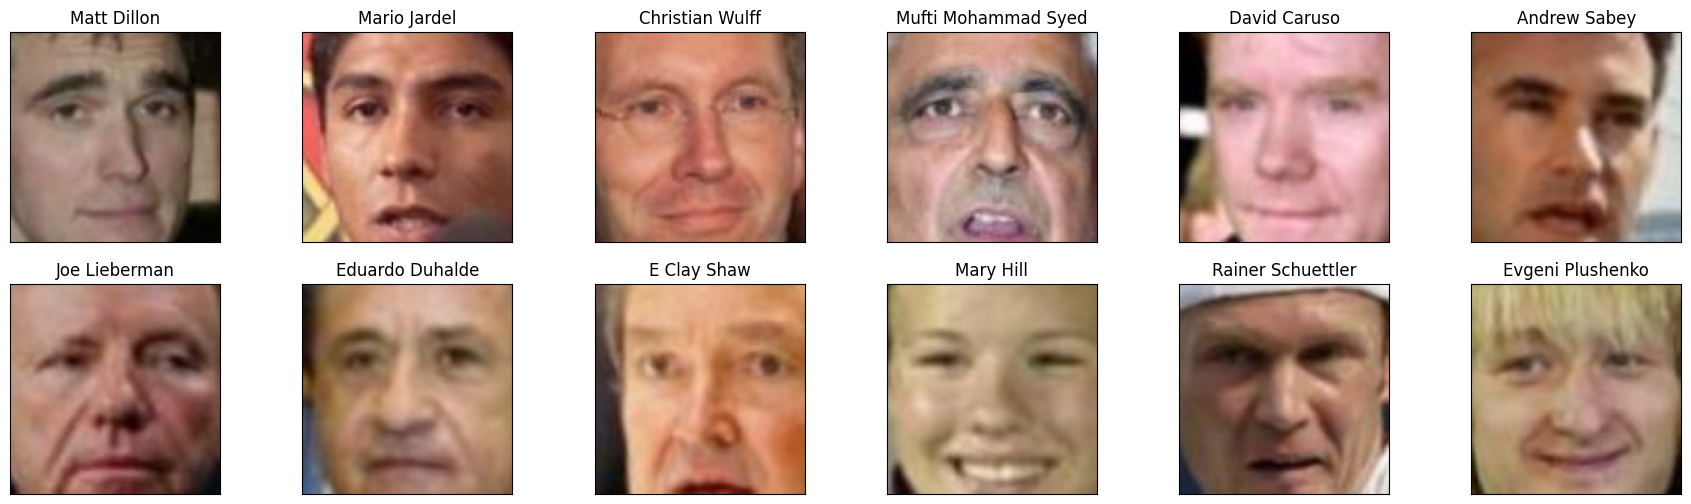

In [ ]:
# визуализация

fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(22, 6), sharey=True, sharex=True)

for fig_x in ax.flatten():
    idx = random.randrange(0, train_photos.shape[0])
    fig_x.imshow(train_photos[idx])
    plt.xticks([])
    plt.yticks([])
    fig_x.set_title(file_attrs['person'].iloc[idx])
    plt.grid(True)
plt.show()

In [ ]:
# загружаем DataLoader

batch_size = 32

train_photos_t = torch.FloatTensor(train_photos).permute(0,3,1,2)
val_photos_t = torch.FloatTensor(val_photos).permute(0,3,1,2)

train_loader = torch.utils.data.DataLoader(train_photos_t, batch_size=batch_size, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_photos_t, batch_size=batch_size, num_workers=2)

1. Архитектура модели Vanilla Autoencoder

In [ ]:
# Архитектура модели

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(

            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.ReLU(),

            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.ReLU(),

            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(init_channels**3, dim_code),
        )

        self.decoder = nn.Sequential(
            nn.Linear(dim_code, init_channels**3),
            nn.Unflatten(dim=1, unflattened_size=(init_channels*4, 16, 16)),

            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum= batchNorm_momentum),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum= batchNorm_momentum),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, sample):
        latent_code = self.encoder(sample)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

    def sample(self, sample):
        reconstruction = self.decoder(sample)
        return reconstruction

Train

In [ ]:
# функция обучения

def train(model, optimizer, criterion, epochs, learning_rate=3e-4, used_sheduler=True):


    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    if used_sheduler:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)


    outputs = []
    train_losses = []
    val_losses = []
    person = file_attrs['person'].tail(5).values.tolist()

    for epoch in tqdm(range(epochs)):

        model.train()  # train mode
        train_losses_per_epoch = []

        for data in train_loader:
            img = data.to(device)
            optimizer.zero_grad()
            recon, _ = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_losses.append(np.mean(train_losses_per_epoch))

        if used_sheduler:
            scheduler.step()

        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for data in val_loader:
                img = data.to(device)
                recon, _ = model(img)
                loss = criterion(recon, img)
                val_losses_per_epoch.append(loss.item())
        val_losses.append(np.mean(val_losses_per_epoch))
        outputs.append((epoch, img, recon),)

        # Save best model weights
        if val_losses[epoch] < best_loss_val:
            best_loss_val = val_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle('%d / %d - train_loss: %f , val_loss: %f' % (epoch+1, epochs, np.mean(train_losses_per_epoch), np.mean(val_losses_per_epoch)),
                     y=1, fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
            if k < 5:
                axis[k].imshow(img[k].detach().cpu().permute(1,2,0))
                axis[k].set_title('Real / ' + person[k])
                axis[k].grid(False)
                axis[k].axis('off')
            elif 4 < k < 10:
                axis[k].imshow(recon[k-5].detach().cpu().permute(1,2,0))
                axis[k].set_title('Reconstruction')
                axis[k].grid(False)
                axis[k].axis('off')
            else:
                axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
                axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
                axis[k].set_xlabel('Epoch')
                axis[k].set_title('MSE loss', fontsize = 16)
                axis[k].legend()
                axis[k].legend(fontsize = 14)
                axis[k].grid(linestyle = "--")
                axis[k].tick_params(labelsize = 14)
                axis[k].set_xlabel("Epoch", fontsize = 14)
                axis[k].set_ylabel("Loss", fontsize = 14)
                axis[k].set_xlim(left = 0, right = len(train_losses))
                axis[k].set_ylim(bottom = 0, top = max(max(train_losses), max(val_losses))*1.2)


        plt.show()

    # best model weights
    model.load_state_dict(best_model_weights)

    # cash clear

    data.to("cpu")
    img.to("cpu")
    recon.to("cpu")
    model.to("cpu")
    del data
    del img
    del recon
    del model
    torch.cuda.empty_cache()


    return outputs, train_losses, val_losses

In [ ]:
# параметры обучения

BASE_DIR = Path('/kaggle/working/')

init_channels = 32 # минимальный размер фильтров в сверточных слоях энкодера/декодера
dim_code = 512 # размерность латентного вектора
image_channels = 3 # количество каналов изображения
epochs = 50 # количество эпох обучения
batchNorm_momentum = 0.1
kernel_size = 3 # базовый размер сверточного ядра
lr = 3e-4 # базовое значение Learning Rate

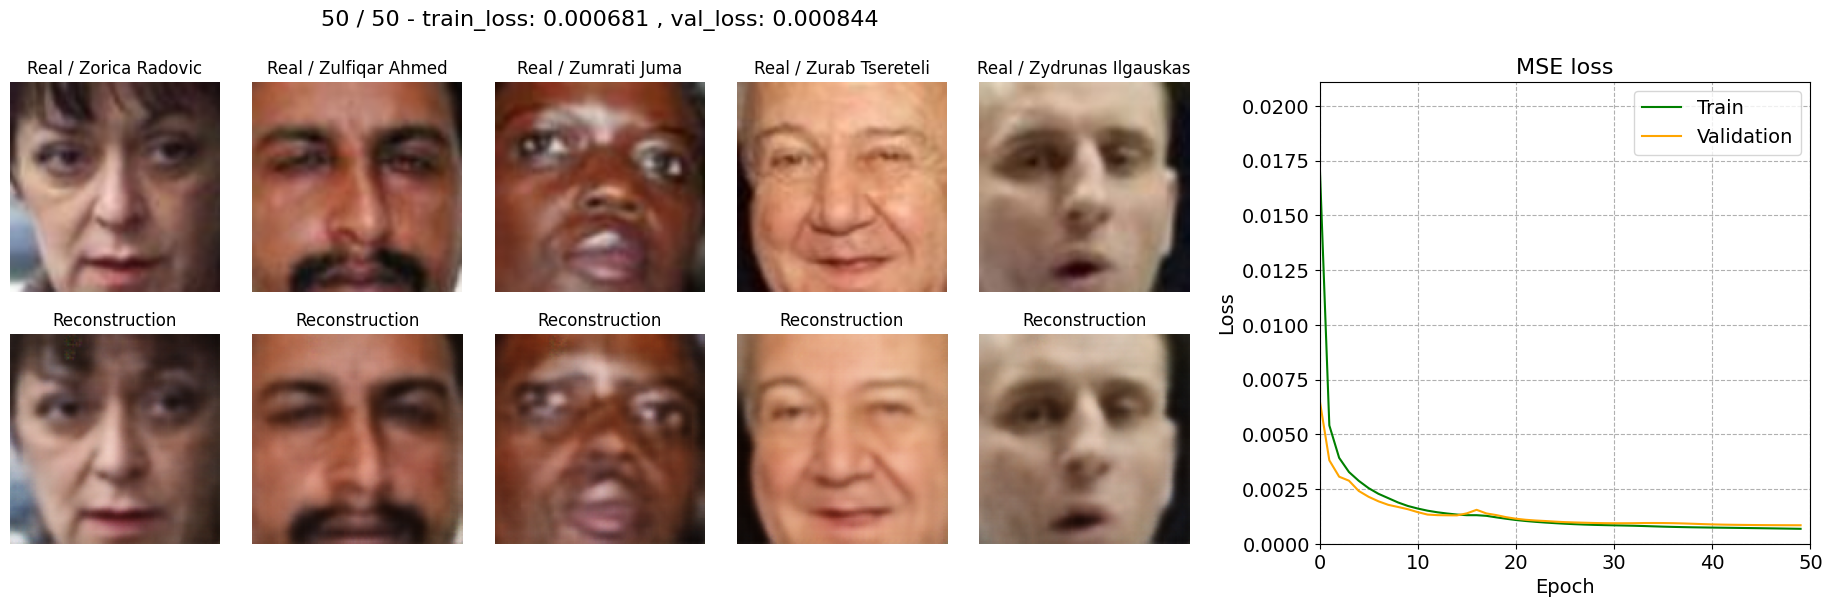

In [ ]:
criterion = nn.MSELoss()
model = Autoencoder().to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

outputs, train_losses, val_losses = train(model, optimizer, criterion, epochs)

In [ ]:
# Сохраняем веса модели
torch.save(model.state_dict(), Path(str(BASE_DIR) + str('/VanillaAE')))

In [ ]:
# загрузка весов
model = Autoencoder().to(device)
model.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/VanillaAE')), map_location=torch.device('cuda')))
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=32768, out_features=512, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=512, out_features=32768, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 16, 16))
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

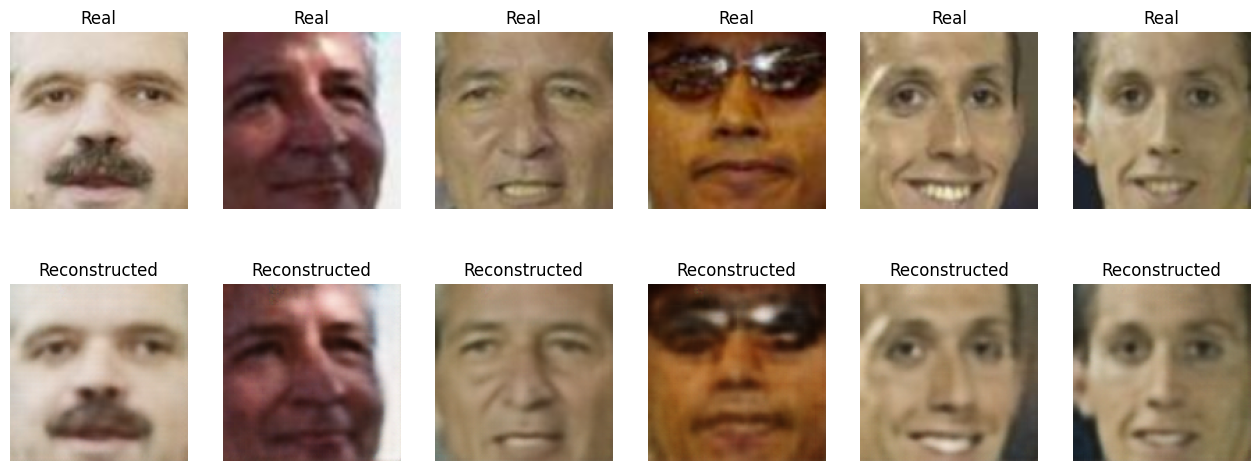

In [ ]:
# выведем первые Х картинок и их реконструкций из val выборки на экран
images = next(iter(val_loader))
with torch.no_grad():
    reconstructed, _ = model(images.to(device))

fig, ax = plt.subplots(2, 6, figsize=(16, 6))
for i in range(2):
    for j in range(6):
        axes = ax[i, j]
        if i == 0:
            axes.imshow(images[j].permute(1,2,0))
            axes.set_title('Real')
        else:
            axes.imshow(reconstructed[j].cpu().permute(1,2,0))
            axes.set_title('Reconstructed')
        axes.axis('off')
plt.show()

Sampling

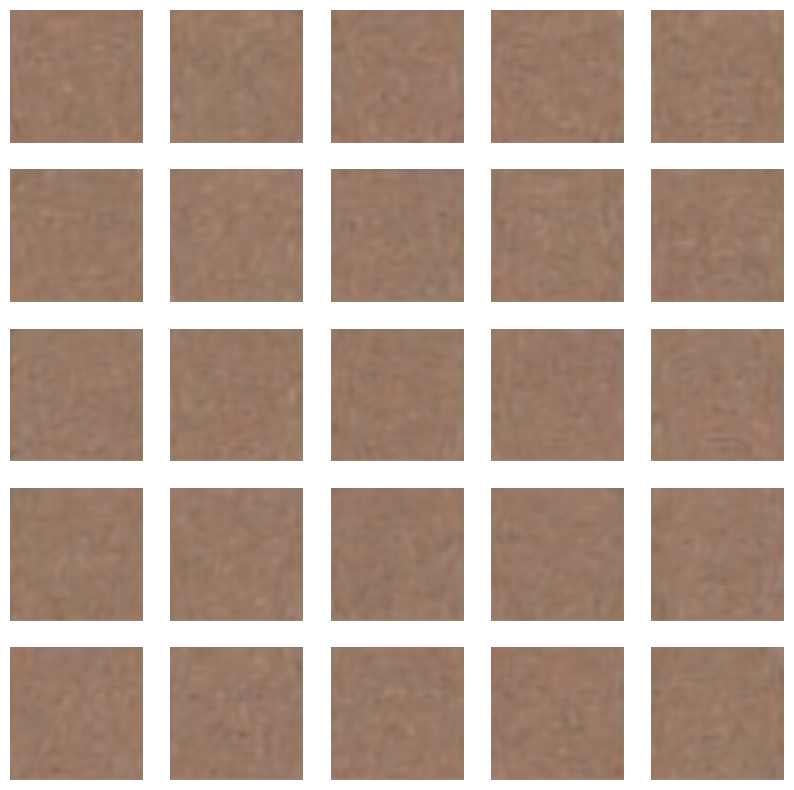

In [ ]:
# сгенерируем 25 рандомных векторов размера dim_code
z = np.random.randn(25, dim_code)
output = model.sample(torch.FloatTensor(z).to(device))


plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i].permute(1,2,0).cpu().detach().numpy()
    plt.imshow(generated)
    plt.axis('off')

plt.show()

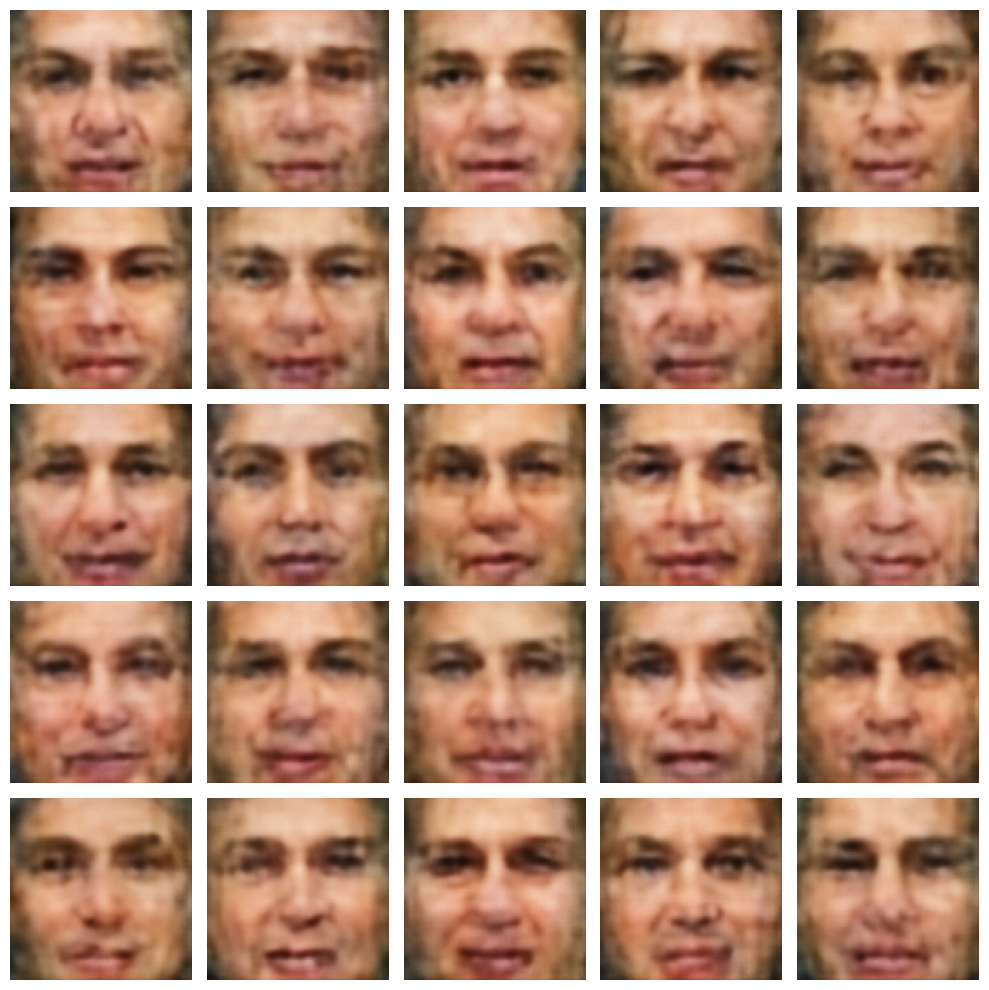

In [ ]:
# сгенерируем 25 нерандомных векторов размера dim_code

count = 0
latents = torch.FloatTensor()
iterator = iter(train_loader)
for i in range(len(train_loader)):
    count += 1
    images = next(iterator)
    model.eval()
    with torch.no_grad():
        _, latent_vector = model(images.to(device))
    latents = torch.cat((latents, latent_vector.to('cpu')), dim=0)

mu = torch.mean(latents, axis=0)   #axis=0 рассчитывает mu поиндексно (попризнаково - от 0 до 511) по всем 10514 векторам
sigma = torch.std(latents, axis=0) #axis=0 рассчитывает sigma поиндексно (попризнаково - от 0 до 511) по всем 10514 векторам

# сгенерируем 25 рандомных векторов размера latent_space
z = 0.5*sigma * torch.randn(25, dim_code) + 2*mu # и добавим немного эмпирических коэффициентов 0.5* и 2*

# восстановленные результаты по скорректированному z
with torch.no_grad():
    output = model.sample(torch.FloatTensor(z).to(device))
# <выведите тут полученные картинки>
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().permute(1,2,0))
        axes.axis('off')
plt.tight_layout()
plt.show()

Smile time

In [ ]:
# Грустные люди (20 шт)
sad_idx = attrs.sort_values('Smiling', ascending=True).where(attrs['Male'] < -2).dropna()[['Smiling', 'Male']].head(20).index.tolist()
# Улыбающиеся люди (20 шт)
smile_idx = attrs.sort_values('Smiling', ascending=False).where(attrs['Male'] < -2).dropna()[['Smiling', 'Male']].head(20).index.tolist()

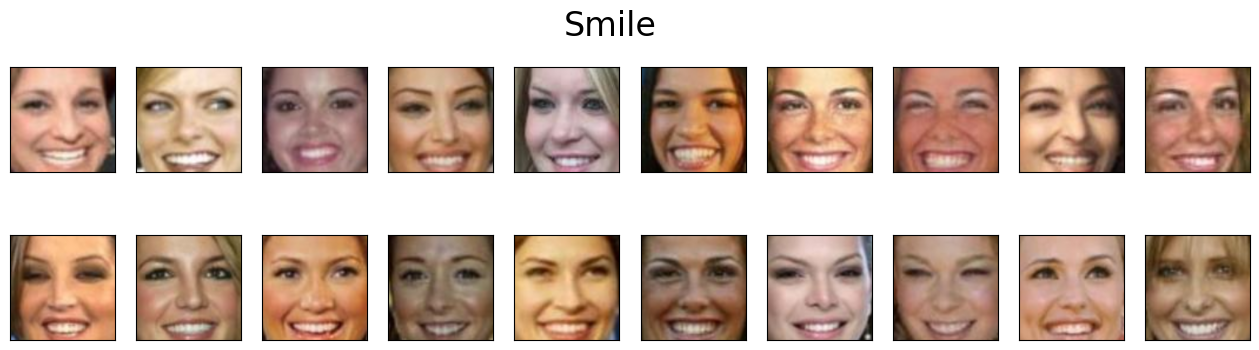

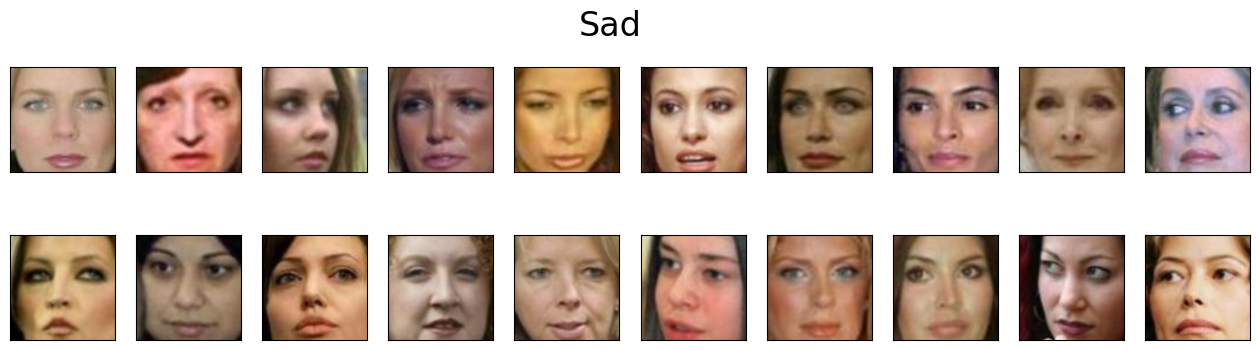

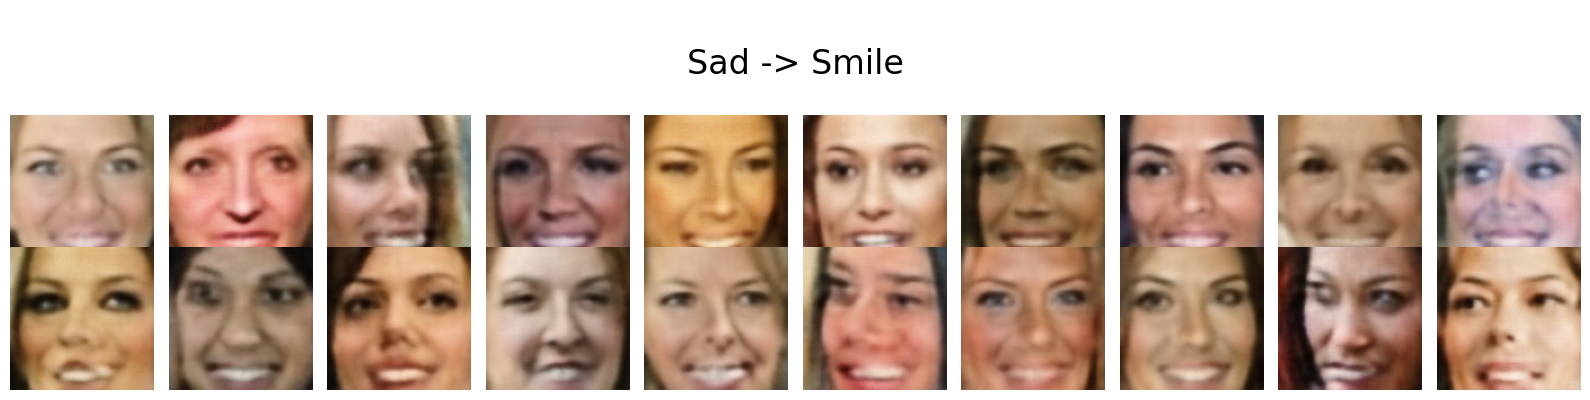

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[smile_idx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Smile', fontsize=24)
plt.show()


fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(16, 4), sharey=True, sharex=True)
count = 0

for fig_x in ax.flatten():
    fig_x.imshow(data[sad_idx[count]])
    plt.xticks([])
    plt.yticks([])
    count += 1
plt.suptitle('Sad', fontsize=24)
plt.show()

latent_smile = torch.FloatTensor().to(device)
latent_sad = torch.FloatTensor().to(device)

# Вычисляем латентный вектор для всех улыбающихся людей
for idx in smile_idx:
    smile_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        _, l_smile = model(smile_image)
    latent_smile = torch.cat((latent_smile, l_smile))

# Вычисляем латентный вектор для всех грустных людей
for idx in sad_idx:
    sad_image = torch.FloatTensor(data[idx]).permute(2, 0, 1).unsqueeze(0).to(device)
    with torch.no_grad():
        _, l_sad = model(sad_image)
    latent_sad = torch.cat((latent_sad, l_sad))

# Определяем вектор улыбки как разность между средним LatVec у улыбающихся и грустных
latent_smile_mean = torch.mean(latent_smile, axis=0)
latent_sad_mean = torch.mean(latent_sad, axis=0)
smile = latent_smile_mean - latent_sad_mean

# Добавим всем грустным немного Радости
latent_sad_with_smile = latent_sad + smile

with torch.no_grad():
    output = model.sample(latent_sad_with_smile)

fig, ax = plt.subplots(2, 10, figsize=(16, 4), sharey=True, sharex=True)
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(output[i].cpu().permute(1,2,0))
    plt.axis('off')
plt.suptitle('\nSad -> Smile', fontsize=24, y=1)
plt.tight_layout()
plt.show()

2. Variational Autoencoder

In [ ]:
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 208674650.01it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 144726038.02it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 175561429.61it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6189255.61it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [ ]:
# параметры обучения

image_channels = 1 # количество каналов изображения
vae_dim_code = 4 # размерность латентного вектора (скрытого пространства)
num_classes = 10 # количество классов

In [ ]:
# Архитектура VAE

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*16, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*16, momentum = batchNorm_momentum),
            nn.LeakyReLU())

        self.mu = nn.Linear(init_channels*16, vae_dim_code)

        self.logsigma = nn.Linear(init_channels*16, vae_dim_code)

        self.decoder_input = nn.Linear(vae_dim_code, init_channels*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels*16, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.reparameterize(mu, logsigma)
        return z

In [ ]:
VAE().to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
# loss функции

def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [ ]:
criterion = loss_vae
vaeautoencoder = VAE().to(device)
optimizer = torch.optim.AdamW(vaeautoencoder.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [ ]:
def train_vae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []

    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(epochs):
        # Train mode
        model.train()
        train_losses_per_epoch = []
        for _, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            X_batch = X_batch[0].to(device)
            reconstructed, mu, logsigma = model(X_batch)
            loss = criterion(X_batch, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)

        if is_scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                X_batch_val = X_batch_val[0].to(device)
                reconstructed_val, mu_val, logsigma_val = model(X_batch_val)
                loss_val = criterion(X_batch_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())

        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))

        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualisations
        clear_output(wait=True)
        fig = plt.figure(figsize=(12,6))
        fig.suptitle(f"{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 6)}, val_loss:{round(val_loss_mean, 6)}", fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
            if k < 5:
                axis[k].imshow(X_batch_val[k].detach().cpu().squeeze(0), cmap='gray')
                axis[k].set_title('Real ' + str(k+1))
                axis[k].grid(False)
                axis[k].axis('off')
            elif 4 < k < 10:
                axis[k].imshow(reconstructed_val[k-5].detach().cpu().squeeze(0), cmap='gray')
                axis[k].set_title('Reconstruction')
                axis[k].grid(False)
                axis[k].axis('off')
            else:
                axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
                axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
                axis[k].set_xlabel('Epoch')
                axis[k].set_title('MSE loss', fontsize = 16)
                axis[k].legend()
                axis[k].legend(fontsize = 14)
                axis[k].grid(linestyle = "--")
                axis[k].tick_params(labelsize = 14)
                axis[k].set_xlabel("Epoch", fontsize = 14)
                axis[k].set_ylabel("Loss", fontsize = 14)
                axis[k].set_xlim(left = 0, right = len(train_losses))
                axis[k].set_ylim(bottom = 3500, top = max(max(train_losses), max(val_losses))*1.05)

        plt.show()

        X_batch.to('cpu')
        del X_batch
        X_batch_val.to('cpu')
        del X_batch_val
        torch.cuda.empty_cache()

        model.load_state_dict(best_model_weights)

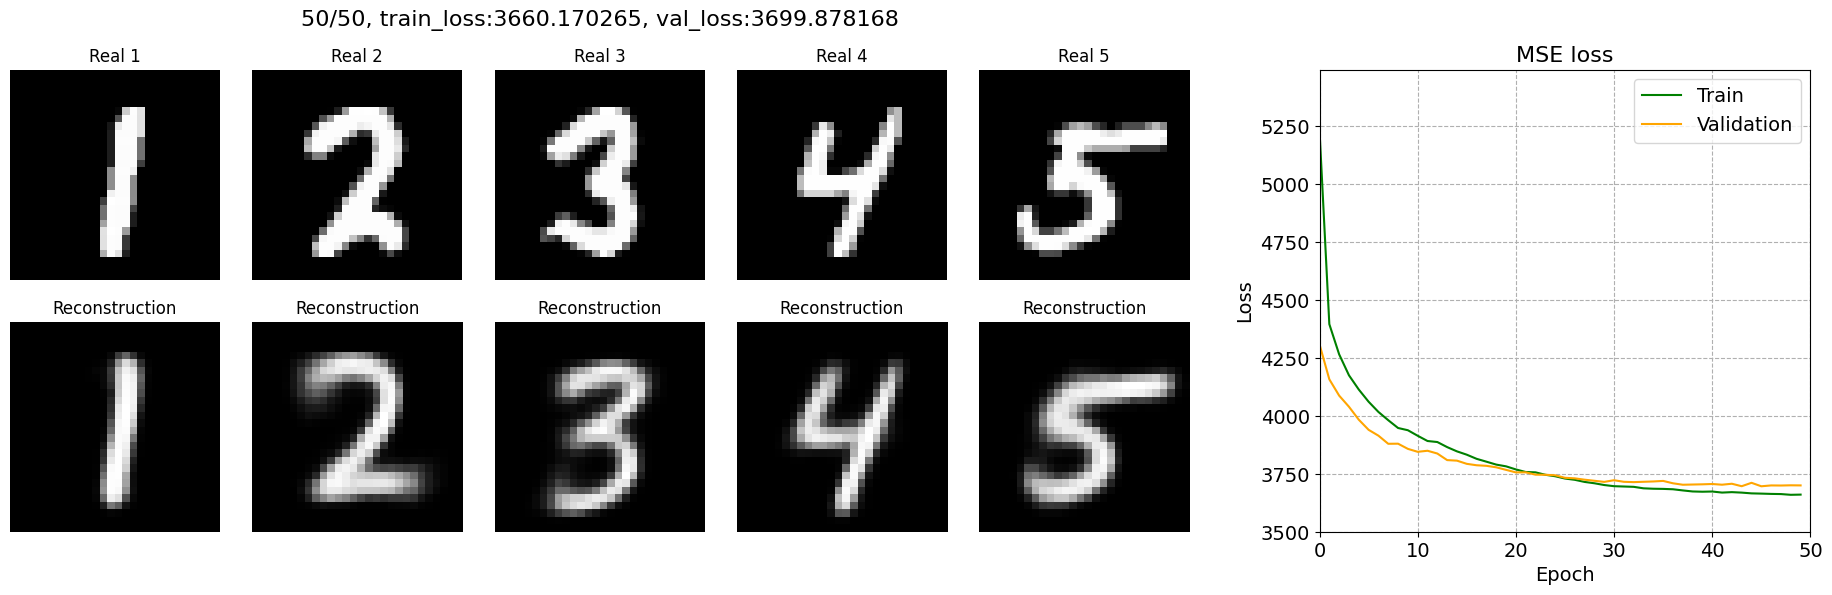

In [ ]:
train_vae(model=vaeautoencoder, optimizer=optimizer, criterion=criterion, epochs=epochs, train_loader=train_loader, val_loader=test_loader)

In [ ]:
# Сохраняем веса модели
torch.save(vaeautoencoder.state_dict(), Path(str(BASE_DIR) + str('/vae')))

In [ ]:
# загрузка весов
vaeautoencoder = VAE().to(device)
vaeautoencoder.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/vae')), map_location=torch.device('cuda')))
vaeautoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track

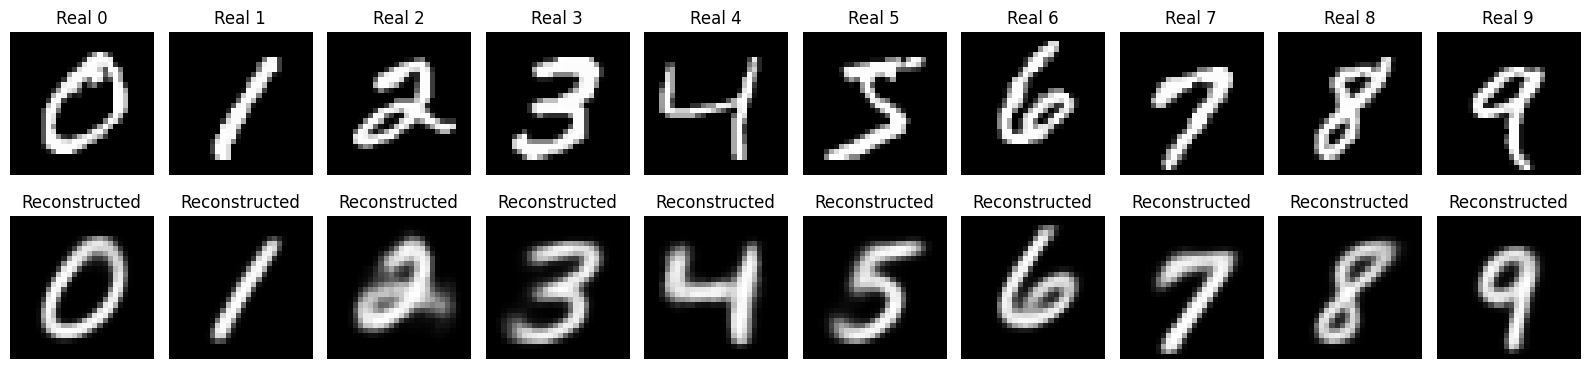

In [ ]:
# проверяем реконструкцию

fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            vaeautoencoder.eval()
            with torch.no_grad():
                reconstructed, mu, logsigma = vaeautoencoder(image.to(device))
            ax[0, i].imshow(torch.squeeze(image.cpu()), cmap='gray')
            ax[0, i].axis('off')
            ax[0, i].set_title('Real '+ str(i))
            ax[1, i].imshow(torch.squeeze(reconstructed.cpu()), cmap='gray')
            ax[1, i].axis('off')
            ax[1, i].set_title('Reconstructed')
            break
plt.tight_layout()
plt.show()

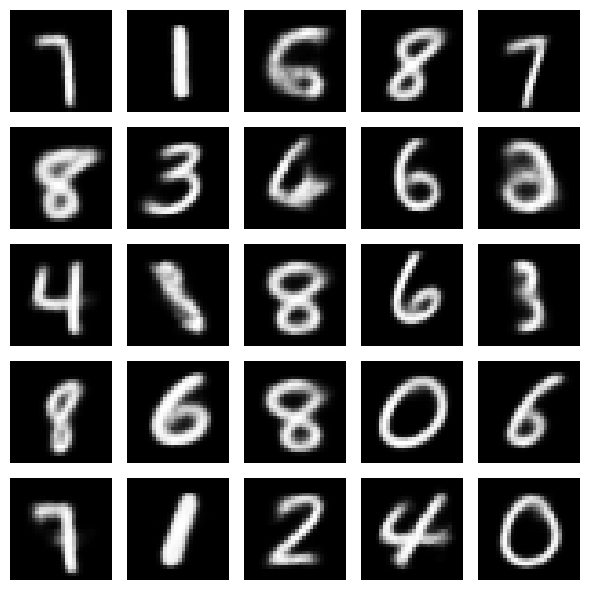

In [ ]:
# сгенерируем 25 нерандомных векторов размера dim_code

z = np.array([np.random.normal(0, 1, vae_dim_code) for i in range(25)])
z = torch.FloatTensor(z)
vaeautoencoder.eval()
with torch.no_grad():
    output = vaeautoencoder.decode(z.to(device))
# <выведите тут полученные картинки>
fig, ax = plt.subplots(5, 5, figsize=(6, 6))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Список всех меток
labels = [i[1] for i in test_dataset]

latents = torch.FloatTensor()
iterator = iter(test_loader)
for i in range(len(test_loader)):
    images = next(iterator)
    images = images[0]
    vaeautoencoder.eval()
    with torch.no_grad():
        latent = vaeautoencoder.get_latent_vector(images.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [ ]:
latents_tsne = TSNE(n_components=2).fit_transform(latents)

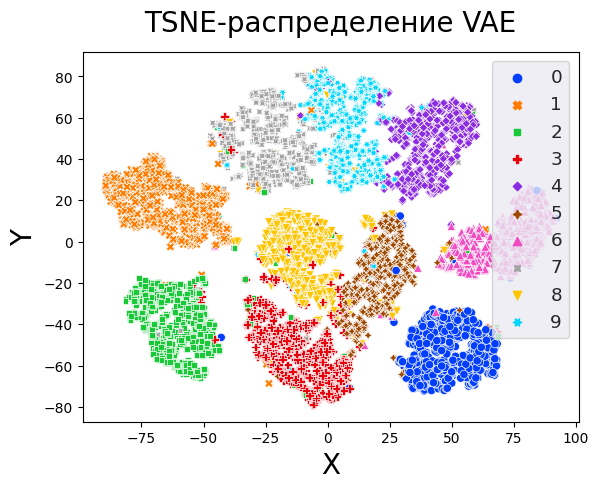

In [ ]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('TSNE-распределение VAE', fontsize =20, pad = 15)
ax.set_xlabel('X', fontsize =20)
ax.set_ylabel('Y', fontsize =20)
plt.show()

Распределение хорошо класстеризуется. Ложно-положительных срабатываний в большей степени происходят для цифр с округлыми формами (3 -> 8). В то время как единицы определяются наиболее точно.

In [ ]:
# параметры обучения

cvae_dim_code = 4 # размерность латентного вектора (скрытого пространства)
img_size = 28 # размер изображения

In [ ]:
# Архитектура CVAE

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*2, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*16, kernel_size=kernel_size, stride=2, padding=1),
            nn.BatchNorm2d(num_features = init_channels*16, momentum = batchNorm_momentum),
            nn.LeakyReLU())

        self.mu = nn.Linear(init_channels*16, cvae_dim_code)

        self.logsigma = nn.Linear(init_channels*16, cvae_dim_code)

        self.embed_class = nn.Linear(num_classes, img_size * img_size)

        # в in_channels добавлен дополнительный фильтр для меток (label)
        self.embed_data = nn.ConvTranspose2d(in_channels=image_channels + 1, out_channels=image_channels, kernel_size=1, padding=0, output_padding=0)

        self.decoder_input = nn.Linear(cvae_dim_code + num_classes, init_channels*16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels*16, out_channels=init_channels*8, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*8, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels*4, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=init_channels*2, kernel_size=kernel_size, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(num_features = init_channels*2, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels*2, out_channels=init_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(num_features = init_channels, momentum = batchNorm_momentum),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=init_channels, out_channels=image_channels, kernel_size=kernel_size, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())

    def reparameterize(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        embedded_class = self.embed_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        x = torch.cat([x, embedded_class], dim=1)
        x = self.embed_data(x)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, labels

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            samples = self.reparameterize(mu, logsigma)
            return samples
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, label):
        labels = F.one_hot(label, num_classes=10)
        labels = labels.type_as(torch.FloatTensor()).to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction


    def forward(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        z = torch.cat([z, labels], dim=1)
        z = self.decoder_input(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.reparameterize(mu, logsigma)
        return z

In [ ]:
for batch in train_loader:
    image, label = batch
    break
model=CVAE().to(device)

In [ ]:
criterion = loss_vae
cvaeautoencoder = CVAE().to(device)
optimizer = torch.optim.AdamW(cvaeautoencoder.parameters(),lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=1e-5, amsgrad=False)

In [ ]:
def train_cvae(model, optimizer, criterion, epochs, train_loader, val_loader, is_scheduler=True):
    train_losses = []
    val_losses = []

    # Set default parameters for saving model weights
    best_model_weights = model.state_dict()
    best_loss_val = np.inf

    if is_scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    for epoch in range(epochs):
        # Train mode
        model.train()

        train_losses_per_epoch = []
        for _, X_batch in enumerate(train_loader):
            optimizer.zero_grad()
            images, labels = X_batch
            images = images.to(device)
            labels = labels.to(device)
            reconstructed, mu, logsigma = model(images, labels)
            loss = criterion(images, mu, logsigma, reconstructed)
            loss.backward()
            optimizer.step()
            train_losses_per_epoch.append(loss.item())

        train_loss_mean = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss_mean)

        if is_scheduler:
            scheduler.step()

        # Validation
        model.eval()
        val_losses_per_epoch = []
        with torch.no_grad():
            for X_batch_val in val_loader:
                images_val, labels_val = X_batch_val
                images_val = images_val.to(device)
                labels_val = labels_val.to(device)
                reconstructed_val, mu_val, logsigma_val = model(images_val, labels_val)
                loss_val = criterion(images_val, mu_val, logsigma_val, reconstructed_val)
                val_losses_per_epoch.append(loss_val.item())

        val_loss_mean = np.mean(val_losses_per_epoch)
        val_losses.append(np.mean(val_loss_mean))

        # Save best model weights
        if val_loss_mean < best_loss_val:
            best_loss_val = val_loss_mean
            best_model_weights = copy.deepcopy(model.state_dict())

        # Visualisations
        clear_output(wait=True)

        fig = plt.figure(figsize=(12,6))
        fig.suptitle(f"{epoch+1}/{epochs}, train_loss:{round(train_loss_mean, 6)}, val_loss:{round(val_loss_mean, 6)}", fontsize = 16)

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
            if k < 5:
                axis[k].imshow(images_val[k].detach().cpu().squeeze(0), cmap='gray')
                axis[k].set_title('Real ' + str(k+1))
                axis[k].grid(False)
                axis[k].axis('off')
            elif 4 < k < 10:
                axis[k].imshow(reconstructed_val[k-5].detach().cpu().squeeze(0), cmap='gray')
                axis[k].set_title('Reconstruction')
                axis[k].grid(False)
                axis[k].axis('off')
            else:
                axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
                axis[k].plot(np.arange(len(val_losses)), val_losses, label='Validation', color = "orange")
                axis[k].set_xlabel('Epoch')
                axis[k].set_title('MSE loss', fontsize = 16)
                axis[k].legend()
                axis[k].legend(fontsize = 14)
                axis[k].grid(linestyle = "--")
                axis[k].tick_params(labelsize = 14)
                axis[k].set_xlabel("Epoch", fontsize = 14)
                axis[k].set_ylabel("Loss", fontsize = 14)
                axis[k].set_xlim(left = 0, right = len(train_losses))
                axis[k].set_ylim(bottom = 3400, top = max(max(train_losses), max(val_losses))*1.05)

        #plt.tight_layout()
        plt.show()

        # Delete cache
        images.to('cpu')
        del images
        images_val.to('cpu')
        del images_val
        torch.cuda.empty_cache()

        # load best model weights
        model.load_state_dict(best_model_weights)

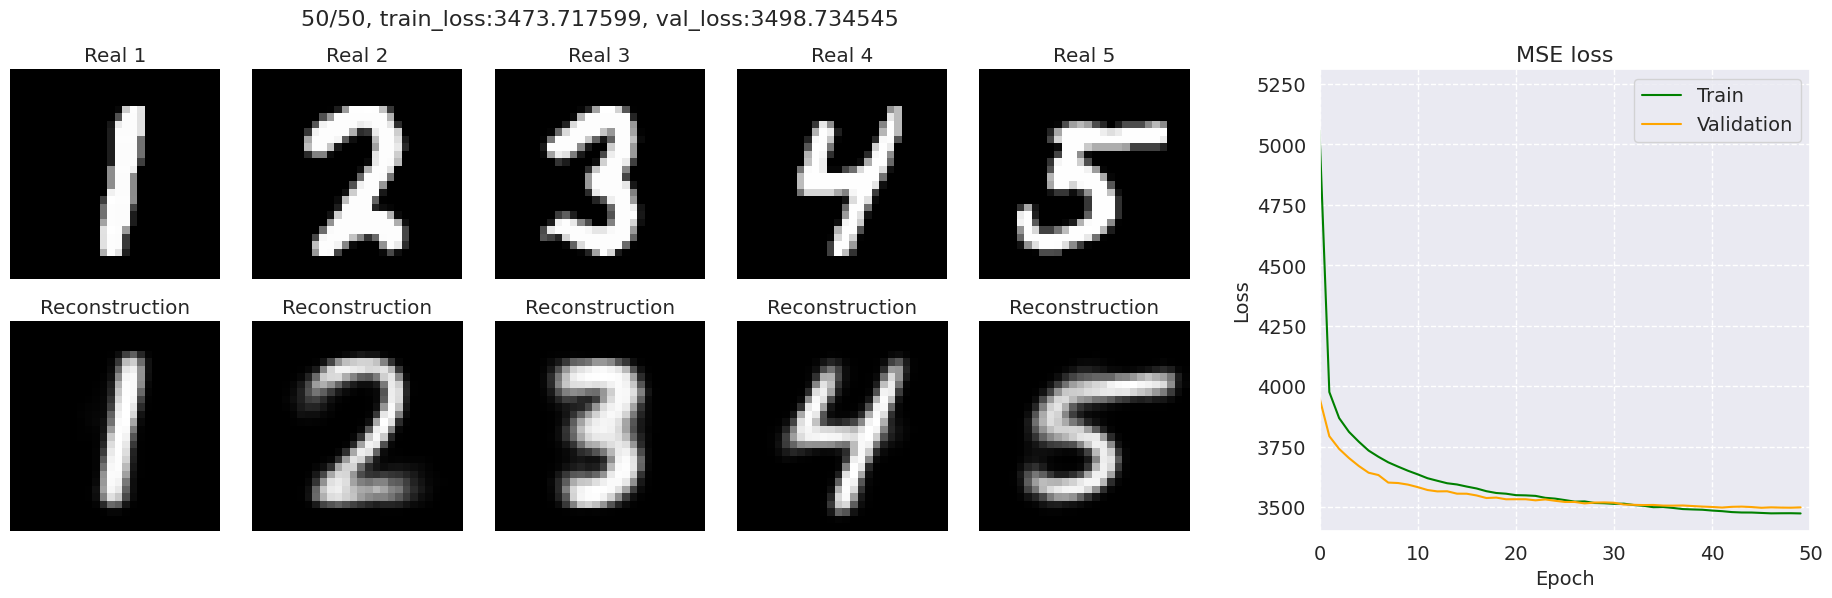

In [ ]:
train_cvae(model=cvaeautoencoder, optimizer=optimizer, criterion=criterion, epochs=epochs, train_loader=train_loader, val_loader=test_loader)

In [ ]:
torch.save(cvaeautoencoder.state_dict(), Path(str(BASE_DIR) + str('/cvae')))

In [ ]:
# загрузка весов
сvaeautoencoder = CVAE().to(device)
сvaeautoencoder.load_state_dict(torch.load(Path(str(BASE_DIR) + str('/cvae')), map_location=torch.device('cuda')))
сvaeautoencoder.eval()

CVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

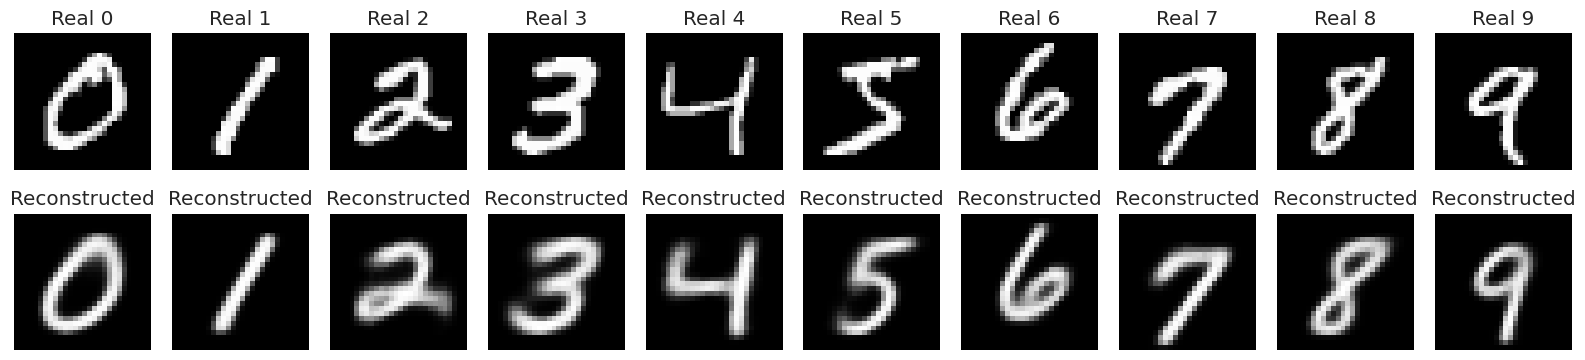

In [ ]:
batch_images = torch.FloatTensor()
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            batch_images = torch.cat((batch_images, image), dim=0)
            break
reconstructed_val, _, _ = cvaeautoencoder(batch_images.to(device), torch.LongTensor(list(range(10))))

fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(10):
    for j in train_dataset:
        if j[1] == i:
            image = torch.FloatTensor(j[0]).unsqueeze(0)
            ax[0, i].imshow(torch.squeeze(image.cpu()), cmap='gray')
            ax[0, i].axis('off')
            ax[0, i].set_title('Real '+ str(i))
            ax[1, i].imshow(torch.squeeze(reconstructed_val[i].detach().cpu()), cmap='gray')
            ax[1, i].axis('off')
            ax[1, i].set_title('Reconstructed')
            break
plt.tight_layout()
plt.show()

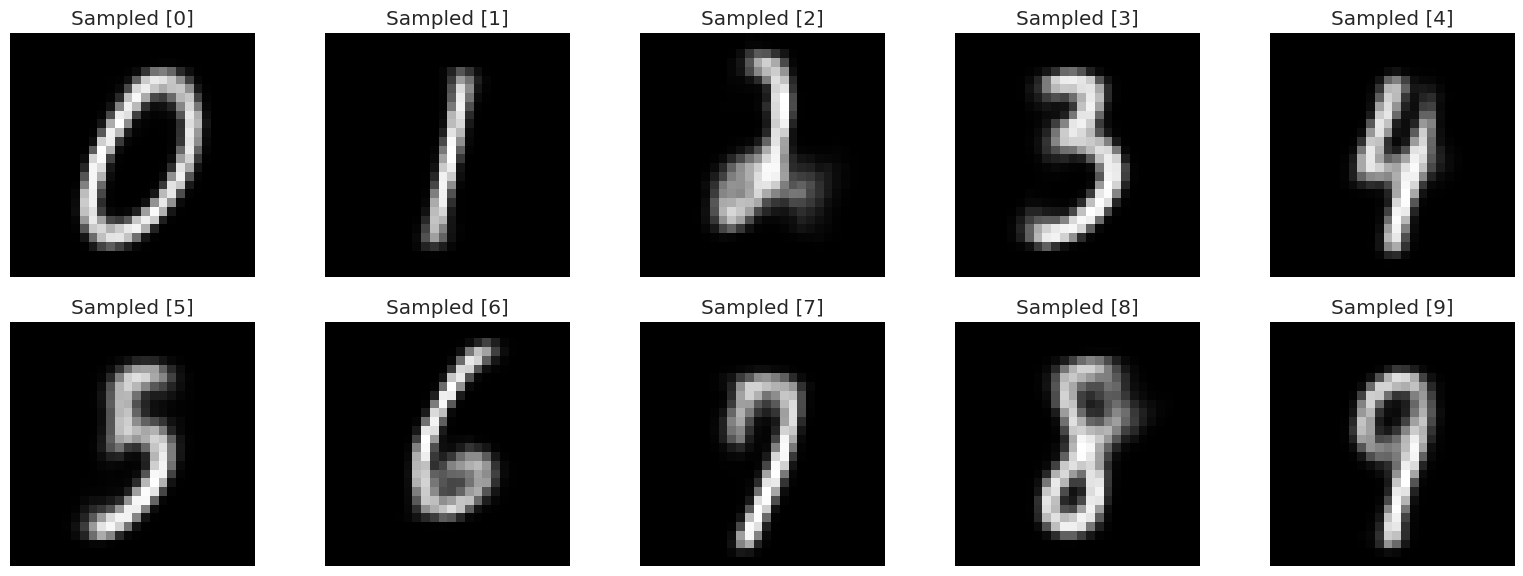

In [ ]:
# сгенерируем 10 нерандомных векторов размера dim_code

z = torch.randn(1, cvae_dim_code)
z = torch.tile(z, dims=(10, 1))
labels = torch.LongTensor(list(range(10)))
cvaeautoencoder.eval()
with torch.no_grad():
    output = cvaeautoencoder.decode(z.to(device), labels.to(device))
fig, ax = plt.subplots(2, 5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5*i+j].cpu().squeeze(0), cmap='gray')
        axes.set_title(f'Sampled {[5*i+j]}')
        axes.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
latents = torch.FloatTensor()

for batch in test_loader:
    images, labels = batch
    cvaeautoencoder.eval()
    with torch.no_grad():
        latent = cvaeautoencoder.get_latent_vector(images.to(device), labels.to(device))
    latents = torch.cat((latents, latent.cpu()))

In [ ]:
latents_tsne = TSNE(n_components=2).fit_transform(latents)

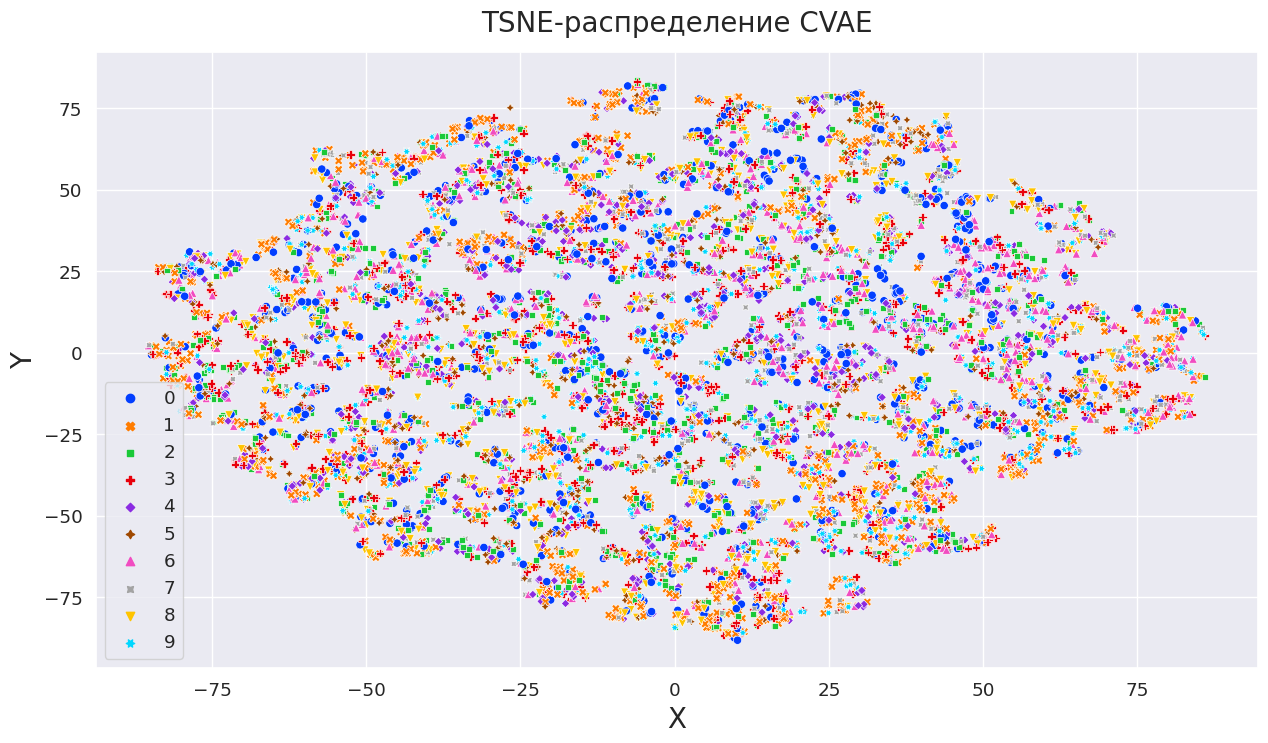

In [ ]:
labels = [i[1] for i in test_dataset]
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize': (15, 8)}, font_scale=1.2, style='darkgrid')
sns.scatterplot(x = latents_tsne[:, 0], y = latents_tsne[:, 1], hue=labels, palette='bright', style=labels)
ax.set_title('TSNE-распределение CVAE', fontsize =20, pad = 15)
ax.set_xlabel('X', fontsize =20)
ax.set_ylabel('Y', fontsize =20)
plt.show()

Распределение носит равномерный характер, не позволяющий осуществить уверенную кластеризацию. Объекты кодируются соответствующими метками, которые позволяют декодеру интерпретировать любую точку скрытого пространства в соответствие с заданной меткой класса.